In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/qa-intents-dataset-university-domain/dataset_test.tsv
/kaggle/input/qa-intents-dataset-university-domain/labels_description.txt
/kaggle/input/qa-intents-dataset-university-domain/dataset_train.tsv


In [2]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import timeit

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset 
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
train_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_train.tsv',delimiter='\t',encoding="utf-8",names=['text', 'intent'])
test_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_test.tsv',delimiter='\t',encoding="utf-8",names=['text', 'intent'])
train_data.head()

,text,intent
0,мне нужна справка,statement_general
1,оформить справку,statement_general
2,взять справку,statement_general
3,справку как получить,statement_general
4,справку ммф где получаться,statement_general


In [6]:
full_data = pd.concat([train_data, test_data])
full_data.head()

,text,intent
0,мне нужна справка,statement_general
1,оформить справку,statement_general
2,взять справку,statement_general
3,справку как получить,statement_general
4,справку ммф где получаться,statement_general


In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(full_data, test_size=0.2, random_state=42)
unique_values_normalized = train['intent'].value_counts(normalize=True)
print(unique_values_normalized*100)

intent
sched_teacher                8.582817
sched_for_group              3.126661
sched_for_group_day          3.046944
wifi                         2.143490
status_free                  2.037201
                               ...   
loc_nsu_cafeteria            0.168291
location_general             0.168291
student_trade_union_enter    0.159433
staff_trade_union_enter      0.159433
loc_passport_office          0.159433
Name: proportion, Length: 142, dtype: float64


In [8]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [9]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Добавление дополнительного измерения
#         print(f'x shape: {x.shape}')
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [10]:
# !
from sklearn.preprocessing import LabelEncoder

# Создание LabelEncoder
le = LabelEncoder()

# Подготовка данных
full_data = pd.concat([train_data, test_data])
train, test = train_test_split(full_data, test_size=0.2, random_state=42)

# Преобразование меток в числовые значения
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])

# # Токенизация и преобразование в TF-IDF
# tokenizer = word_tokenize
# vectorizer = TfidfVectorizer(tokenizer=tokenizer, stop_words='english')

# train_texts = vectorizer.fit_transform(train['text']).toarray()
# test_texts = vectorizer.transform(test['text']).toarray()

# # Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
# train_dataset = TextDataset(torch.from_numpy(train_texts), train_labels)
# test_dataset = TextDataset(torch.from_numpy(test_texts), test_labels)


In [11]:
# Токенизация и преобразование в TF-IDF
tokenizer = word_tokenize
vectorizer = TfidfVectorizer(tokenizer=tokenizer)

train_texts = vectorizer.fit_transform(train['text']).toarray()
test_texts = vectorizer.transform(test['text']).toarray()

# Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
train_dataset = TextDataset(torch.from_numpy(train_texts), train_labels)
test_dataset = TextDataset(torch.from_numpy(test_texts), test_labels)


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
# Подготовка данных
# full_data = pd.concat([train_data, test_data])
# train, test = train_test_split(full_data, test_size=0.2, random_state=42)

# le = LabelEncoder()
# train_labels = le.fit_transform(train['intent'])
# test_labels = le.transform(test['intent'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


100%|██████████| 89/89 [00:00<00:00, 736.73it/s]


Epoch 1, Train Loss: 3.794915510304589, Val Loss: 2.0177572088295155


100%|██████████| 89/89 [00:00<00:00, 923.18it/s]


Epoch 2, Train Loss: 0.9867602566906143, Val Loss: 0.43283047987503953


100%|██████████| 89/89 [00:00<00:00, 957.96it/s]


Epoch 3, Train Loss: 0.26834904107531643, Val Loss: 0.20233406507399646


100%|██████████| 89/89 [00:00<00:00, 903.70it/s]


Epoch 4, Train Loss: 0.1505871563569429, Val Loss: 0.15249666146766605


100%|██████████| 89/89 [00:00<00:00, 985.83it/s]


Epoch 5, Train Loss: 0.11712287014439998, Val Loss: 0.13541692822878615


100%|██████████| 89/89 [00:00<00:00, 752.09it/s]


Epoch 6, Train Loss: 0.10390850304290863, Val Loss: 0.12547728921590226


100%|██████████| 89/89 [00:00<00:00, 854.35it/s]


Epoch 7, Train Loss: 0.0968844060602706, Val Loss: 0.12491955676670657


100%|██████████| 89/89 [00:00<00:00, 940.30it/s]


Epoch 8, Train Loss: 0.09323948875686983, Val Loss: 0.12313249948685674


100%|██████████| 89/89 [00:00<00:00, 963.45it/s]


Epoch 9, Train Loss: 0.0914801816045763, Val Loss: 0.12137358149597316


100%|██████████| 89/89 [00:00<00:00, 916.53it/s]


Epoch 10, Train Loss: 0.08954083558538713, Val Loss: 0.12332053471021773


100%|██████████| 89/89 [00:00<00:00, 941.33it/s]


Epoch 11, Train Loss: 0.08762946421189481, Val Loss: 0.12035877865168862


100%|██████████| 89/89 [00:00<00:00, 926.68it/s]


Epoch 12, Train Loss: 0.08713901108862943, Val Loss: 0.12013864418716703


100%|██████████| 89/89 [00:00<00:00, 904.22it/s]


Epoch 13, Train Loss: 0.08660255833782873, Val Loss: 0.12434054933569468


100%|██████████| 89/89 [00:00<00:00, 938.17it/s]


Epoch 14, Train Loss: 0.08570437577603221, Val Loss: 0.12420895465471771


100%|██████████| 89/89 [00:00<00:00, 924.15it/s]


Epoch 15, Train Loss: 0.08537619624185645, Val Loss: 0.12590550569545353


100%|██████████| 89/89 [00:00<00:00, 939.15it/s]


Epoch 16, Train Loss: 0.08574607072418843, Val Loss: 0.12650794464162174


100%|██████████| 89/89 [00:00<00:00, 953.20it/s]


Epoch 17, Train Loss: 0.08488072925817786, Val Loss: 0.12758158374246828


100%|██████████| 89/89 [00:00<00:00, 954.14it/s]


Epoch 18, Train Loss: 0.08512101591260156, Val Loss: 0.12689375290529425


100%|██████████| 89/89 [00:00<00:00, 901.75it/s]


Epoch 19, Train Loss: 0.08458171927461812, Val Loss: 0.1275453410298417


100%|██████████| 89/89 [00:00<00:00, 942.17it/s]


Epoch 20, Train Loss: 0.0847287086945592, Val Loss: 0.1312065372961963


100%|██████████| 89/89 [00:00<00:00, 967.80it/s]


Epoch 21, Train Loss: 0.08439965572442068, Val Loss: 0.13190266073323667


100%|██████████| 89/89 [00:00<00:00, 942.65it/s]


Epoch 22, Train Loss: 0.08401222600314368, Val Loss: 0.1296434008014085


100%|██████████| 89/89 [00:00<00:00, 933.03it/s]


Epoch 23, Train Loss: 0.08395594638117185, Val Loss: 0.13335821181084448


100%|██████████| 89/89 [00:00<00:00, 896.42it/s]


Epoch 24, Train Loss: 0.08359237491061994, Val Loss: 0.13300120806664206


100%|██████████| 89/89 [00:00<00:00, 943.38it/s]


Epoch 25, Train Loss: 0.08371523207422864, Val Loss: 0.13723412908700666


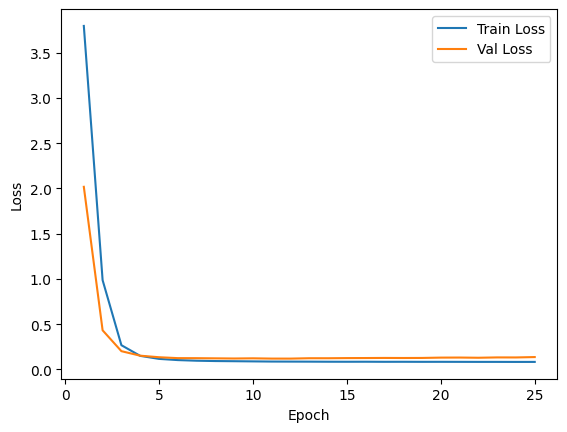

In [13]:
# Создание и обучение модели
model = LSTMClassifier(input_dim=train_texts.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Перемещение модели на GPU, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

n_epoches = 25

for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0
    # Обучение
    model.train()
    for i, (texts, labels) in enumerate(tqdm(train_loader)):
        # Перемещение данных на тот же устройство, что и модель
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for i, (texts, labels) in enumerate(tqdm(test_loader)):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Построение графика потерь
plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
# # Прогнозирование на тестовом наборе
# predictions = []
# with torch.no_grad():
#     for i, (input_ids, labels) in enumerate(test_loader):
#         input_ids = input_ids.float().to(device)

#         outputs = model(input_ids)
#         _, predicted = torch.max(outputs.data, 1)
#         predictions.extend(predicted.cpu().numpy())

# # Перевод меток обратно в исходные интенты
# predicted_intents = le.inverse_transform(predictions)

# print(balanced_accuracy_score(test_labels, predictions))
# print(precision_recall_fscore_support(test_labels, predictions, average = 'weighted'))

In [15]:
# Прогнозирование на тестовом наборе
predictions = []
start_test = timeit.default_timer()
with torch.no_grad():
    for i, (input_ids, labels) in enumerate(test_loader):
        input_ids = input_ids.float().to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
end_test = timeit.default_timer()

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')
print(balanced_accuracy_score(test_labels, predictions))
print(precision_recall_fscore_support(test_labels, predictions, average='weighted'))

Time for testing: 0.1173 seconds
Average time per response: 0.000042 seconds
0.9517923417003294
(0.9497828239238355, 0.9486362026213249, 0.9476604382969815, None)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# Сохранение входных данных, истинных меток и предсказаний в DataFrame
results_df = pd.DataFrame({
    'Input': test['text'],
    'True Label': test['intent'],
    'Predicted Label': predicted_intents
})

# Сохранение DataFrame в CSV файл
results_df.to_csv('model_predictions.csv', index=False)

# Вывод первых нескольких строк для проверки
print(results_df.head())
print(results_df[results_df['True Label']!=results_df['Predicted Label']])

                                                 Input  \
8079              распологается где расписание занятий   
4950                      усваивать семинарист сколько   
9941                            где есть экзамен число   
600   как мне заказать разрешение на внос оборудования   
1121                               где есть деканат эф   

                   True Label          Predicted Label  
8079           sched_location           sched_location  
4950   stat_numb_of_academics   stat_numb_of_academics  
9941               sched_exam               sched_exam  
600   student_union_equipment  student_union_equipment  
1121              loc_dean_ef              loc_dean_ef  
                                                  Input  \
2342                   институт электрометрии раскопать   
2662                      пройти институт электрометрии   
2150  институт автоматики и электрометрии со ран рас...   
2444              расположен где институт электрометрии   
2495          

mini-LM

In [17]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score

In [18]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [19]:
# Создание пользовательского Dataset класса
class TextDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


In [20]:
# Определение модели LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hn, _) = self.lstm(x.unsqueeze(1))
        out = self.fc(hn[-1])
        return out

In [21]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Load your dataset
train_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_train.tsv', delimiter='\t', encoding="utf-8", names=['text', 'intent'])
test_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_test.tsv', delimiter='\t', encoding="utf-8", names=['text', 'intent'])
full_data = pd.concat([train_data, test_data])

# Split the data into train and test sets
train, test = train_test_split(full_data, test_size=0.2, random_state=42)

# Tokenize and encode the text data
train_encodings = tokenizer(train['text'].tolist(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test['text'].tolist(), truncation=True, padding=True, return_tensors="pt")

# Extract embeddings
with torch.no_grad():
    train_embeddings = model(**train_encodings).pooler_output
    test_embeddings = model(**test_encodings).pooler_output

le = LabelEncoder()

# Преобразование меток в числовые значения
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])


# Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
train_dataset = TextDataset(train_embeddings, torch.tensor(train_labels))
test_dataset = TextDataset(test_embeddings, torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
# Создание и обучение модели
model = LSTMClassifier(input_dim=train_embeddings.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Перемещение модели на GPU, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

n_epoches = 25

for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0
    # Обучение
    model.train()
    for texts, labels in tqdm(train_loader):
        # Перемещение данных на тот же устройство, что и модель
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for texts, labels in tqdm(test_loader):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Построение графика потерь
plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# # Прогнозирование на тестовом наборе
# predictions = []
# with torch.no_grad():
#     for i, (input_ids, labels) in enumerate(test_loader):
#         input_ids = input_ids.float().to(device)

#         outputs = model(input_ids)
#         _, predicted = torch.max(outputs.data, 1)
#         predictions.extend(predicted.cpu().numpy())

# # Перевод меток обратно в исходные интенты
# predicted_intents = le.inverse_transform(predictions)

In [ ]:
# Прогнозирование на тестовом наборе
predictions = []
start_test = timeit.default_timer()
with torch.no_grad():
    for i, (input_ids, labels) in enumerate(test_loader):
        input_ids = input_ids.float().to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
end_test = timeit.default_timer()

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')
print("precision_recall_fscore weighted", precision_recall_fscore_support(test['intent'], predicted_intents, average='weighted'))
print("balanced_accuracy", balanced_accuracy_score(test['intent'], predicted_intents))

In [ ]:
# print("precision_recall_fscore weighted", precision_recall_fscore_support(test['intent'], predicted_intents, average='weighted'))
# print("balanced_accuracy", balanced_accuracy_score(test['intent'], predicted_intents))

In [ ]:
# Сохранение входных данных, истинных меток и предсказаний в DataFrame
results_df = pd.DataFrame({
    'Input': test['text'],
    'True Label': test['intent'],
    'Predicted Label': predicted_intents
})

# Сохранение DataFrame в CSV файл
results_df.to_csv('model_predictions.csv', index=False)

# Вывод первых нескольких строк для проверки
print(results_df.head())
print(results_df[results_df['True Label']!=results_df['Predicted Label']])

M-USE

In [22]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sadakmed/distiluse-base-multilingual-cased-v2")
model = AutoModel.from_pretrained("sadakmed/distiluse-base-multilingual-cased-v2")

tokenizer_config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/539M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [23]:
# Tokenize and encode the text data
train_encodings = tokenizer(train['text'].tolist(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test['text'].tolist(), truncation=True, padding=True, return_tensors="pt")

# Извлечение эмбеддингов
with torch.no_grad():
    train_embeddings = model(**train_encodings).last_hidden_state.mean(dim=1)
    test_embeddings = model(**test_encodings).last_hidden_state.mean(dim=1)

le = LabelEncoder()

# Преобразование меток в числовые значения
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])


# Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
train_dataset = TextDataset(train_embeddings, torch.tensor(train_labels))
test_dataset = TextDataset(test_embeddings, torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [24]:
# Создание и обучение модели
model = LSTMClassifier(input_dim=train_embeddings.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Перемещение модели на GPU, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

n_epoches = 25

In [25]:
for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0
    # Обучение
    model.train()
    for texts, labels in tqdm(train_loader):
        # Перемещение данных на тот же устройство, что и модель
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for texts, labels in tqdm(test_loader):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

100%|██████████| 89/89 [00:00<00:00, 1261.26it/s]


Epoch 1, Train Loss: 2.5495952094242864, Val Loss: 1.027003742670745


100%|██████████| 89/89 [00:00<00:00, 1297.80it/s]


Epoch 2, Train Loss: 0.60566470086068, Val Loss: 0.41288171524412176


100%|██████████| 89/89 [00:00<00:00, 1277.97it/s]


Epoch 3, Train Loss: 0.2930299800322009, Val Loss: 0.2585851956954163


100%|██████████| 89/89 [00:00<00:00, 1288.89it/s]


Epoch 4, Train Loss: 0.19851472122177863, Val Loss: 0.19488207418262288


100%|██████████| 89/89 [00:00<00:00, 1226.58it/s]


Epoch 5, Train Loss: 0.15627091499335705, Val Loss: 0.16083142902241665


100%|██████████| 89/89 [00:00<00:00, 1274.22it/s]


Epoch 6, Train Loss: 0.1326659203008366, Val Loss: 0.13905909278670722


100%|██████████| 89/89 [00:00<00:00, 1278.97it/s]


Epoch 7, Train Loss: 0.1188933479285696, Val Loss: 0.1348228712639447


100%|██████████| 89/89 [00:00<00:00, 1267.77it/s]


Epoch 8, Train Loss: 0.11193357929903962, Val Loss: 0.12519495898669356


100%|██████████| 89/89 [00:00<00:00, 1260.50it/s]


Epoch 9, Train Loss: 0.10468751367936095, Val Loss: 0.11864430759771821


100%|██████████| 89/89 [00:00<00:00, 1235.40it/s]


Epoch 10, Train Loss: 0.10103310877984922, Val Loss: 0.11890825909677516


100%|██████████| 89/89 [00:00<00:00, 1237.20it/s]


Epoch 11, Train Loss: 0.09676240757569439, Val Loss: 0.11189500703947262


100%|██████████| 89/89 [00:00<00:00, 1229.78it/s]


Epoch 12, Train Loss: 0.09585703163844383, Val Loss: 0.11134915286675096


100%|██████████| 89/89 [00:00<00:00, 1233.17it/s]


Epoch 13, Train Loss: 0.0930806699369852, Val Loss: 0.1107677410832826


100%|██████████| 89/89 [00:00<00:00, 1227.65it/s]


Epoch 14, Train Loss: 0.09249722748393294, Val Loss: 0.1114690938331396


100%|██████████| 89/89 [00:00<00:00, 1238.05it/s]


Epoch 15, Train Loss: 0.09203813952412299, Val Loss: 0.10709255962538418


100%|██████████| 89/89 [00:00<00:00, 1306.24it/s]


Epoch 16, Train Loss: 0.09096939972121659, Val Loss: 0.10963974717685304


100%|██████████| 89/89 [00:00<00:00, 1281.16it/s]


Epoch 17, Train Loss: 0.08947421500453377, Val Loss: 0.10577024414277311


100%|██████████| 89/89 [00:00<00:00, 1240.17it/s]


Epoch 18, Train Loss: 0.08919215113404089, Val Loss: 0.10282126574232923


100%|██████████| 89/89 [00:00<00:00, 1235.80it/s]


Epoch 19, Train Loss: 0.0884931725778824, Val Loss: 0.10761110843002294


100%|██████████| 89/89 [00:00<00:00, 1247.80it/s]


Epoch 20, Train Loss: 0.0885287107706529, Val Loss: 0.10305169473658578


100%|██████████| 89/89 [00:00<00:00, 1257.17it/s]


Epoch 21, Train Loss: 0.08820455199372677, Val Loss: 0.10613819996413011


100%|██████████| 89/89 [00:00<00:00, 1226.27it/s]


Epoch 22, Train Loss: 0.08851129646566709, Val Loss: 0.10349879739348243


100%|██████████| 89/89 [00:00<00:00, 1292.57it/s]


Epoch 23, Train Loss: 0.08691809578434626, Val Loss: 0.11198897814781018


100%|██████████| 89/89 [00:00<00:00, 1244.75it/s]


Epoch 24, Train Loss: 0.08758203247530721, Val Loss: 0.10654451629785255


100%|██████████| 89/89 [00:00<00:00, 1253.07it/s]

Epoch 25, Train Loss: 0.08783994931312114, Val Loss: 0.10437286470812651


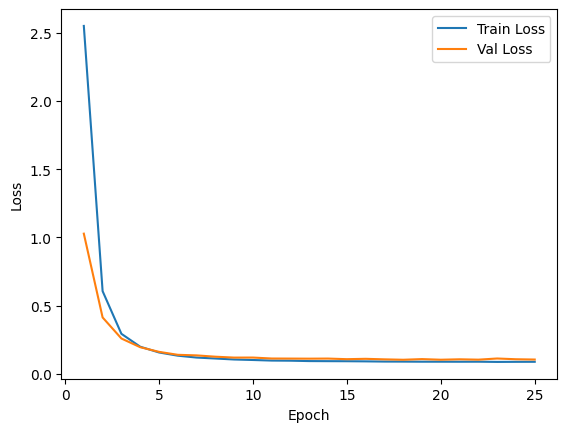

In [26]:
# Построение графика потерь
plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
# # Прогнозирование на тестовом наборе
# predictions = []
# with torch.no_grad():
#     for i, (input_ids, labels) in enumerate(test_loader):
#         input_ids = input_ids.float().to(device)

#         outputs = model(input_ids)
#         _, predicted = torch.max(outputs.data, 1)
#         predictions.extend(predicted.cpu().numpy())

# # Перевод меток обратно в исходные интенты
# predicted_intents = le.inverse_transform(predictions)

# print("precision_recall_fscore weighted", precision_recall_fscore_support(test['intent'], predicted_intents, average='weighted'))
# print("balanced_accuracy", balanced_accuracy_score(test['intent'], predicted_intents))

In [28]:
# Прогнозирование на тестовом наборе
predictions = []
start_test = timeit.default_timer()
with torch.no_grad():
    for i, (input_ids, labels) in enumerate(test_loader):
        input_ids = input_ids.float().to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
end_test = timeit.default_timer()

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')
print("precision_recall_fscore weighted", precision_recall_fscore_support(test['intent'], predicted_intents, average='weighted'))
print("balanced_accuracy", balanced_accuracy_score(test['intent'], predicted_intents))

Time for testing: 0.0695 seconds
Average time per response: 0.000025 seconds
precision_recall_fscore weighted (0.9533388347046118, 0.9543039319872476, 0.9530992226859517, None)
balanced_accuracy 0.9554756211446351


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# Сохранение входных данных, истинных меток и предсказаний в DataFrame
results_df = pd.DataFrame({
    'Input': test['text'],
    'True Label': test['intent'],
    'Predicted Label': predicted_intents
})

# Сохранение DataFrame в CSV файл
results_df.to_csv('model_predictions.csv', index=False)


# print(results_df[results_df['True Label']!=results_df['Predicted Label']])

In [30]:
# Вывод первых нескольких строк для проверки
print(results_df.head(12))

                                                 Input  \
8079              распологается где расписание занятий   
4950                      усваивать семинарист сколько   
9941                            где есть экзамен число   
600   как мне заказать разрешение на внос оборудования   
1121                               где есть деканат эф   
3821                                       комиссариат   
6595                        где есть основа бюджетный.   
2935                       новое здание НГУ пожалуйста   
5762                               абонентнсунетстать!   
2342                  институт электрометрии раскопать   
7346                               атм расположен где)   
9615                    получаться wifi в университете   

                   True Label          Predicted Label  
8079           sched_location           sched_location  
4950   stat_numb_of_academics   stat_numb_of_academics  
9941               sched_exam               sched_exam  
600   student_uni

In [31]:
print(results_df[results_df['True Label']!=results_df['Predicted Label']])

                                                  Input  \
2662                      пройти институт электрометрии   
2444              расположен где институт электрометрии   
2495                  институт электрометрии обнаружить   
7720                        заказать справка о обучении   
2473                     доехать институт электрометрии   
...                                                 ...   
2218                   институт электрометрии находится   
2238  институт автоматики и электрометрии со ран нах...   
2089              распологается где институт автоматики   
175   как пройти институт автоматики и электрометрии...   
6072                               как можно посидетьа?   

                               True Label                      Predicted Label  
2662               loc_termophysinstitute               loc_philologyinstitute  
2444                     loc_lawinstitute  loc_automationelectrometryinstitute  
2495                    loc_chiminstitute       